In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import os
import time
import sys
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [7]:
train_file = './data/train.csv'
eval_file = './data/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [8]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [11]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [12]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


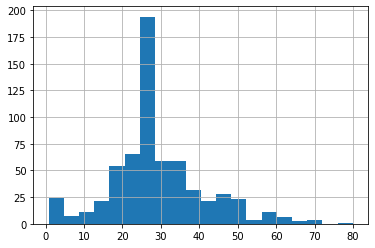

In [13]:
train_df.age.hist(bins = 20)

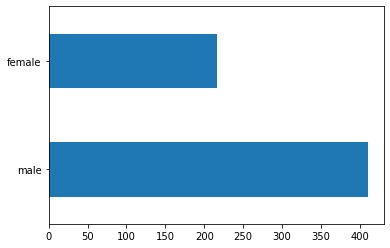

In [18]:
train_df.sex.value_counts().plot(kind = 'barh')

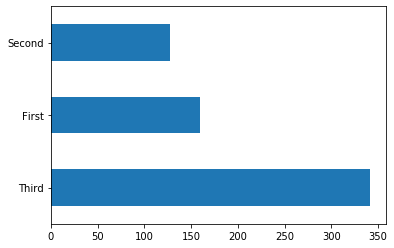

In [19]:
train_df['class'].value_counts().plot(kind = 'barh')

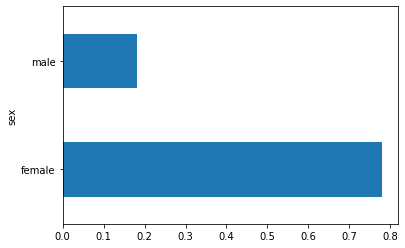

In [21]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [22]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                      'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [23]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [24]:
train_dataset = make_dataset(train_df, y_train, batch_size =5)

In [25]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=38, shape=(5,), dtype=string, numpy=array([b'female', b'male', b'male', b'male', b'female'], dtype=object)>, 'age': <tf.Tensor: id=30, shape=(5,), dtype=float64, numpy=array([31.,  2., 28., 28., 58.])>, 'n_siblings_spouses': <tf.Tensor: id=36, shape=(5,), dtype=int32, numpy=array([0, 3, 0, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: id=37, shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 1], dtype=int32)>, 'fare': <tf.Tensor: id=35, shape=(5,), dtype=float64, numpy=array([  8.6833,  21.075 ,  10.5   ,   7.75  , 153.4625])>, 'class': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=33, shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'C'], dtype=object)>, 'embark_town': <tf.Tensor: id=34, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Queenstown',
       b'Southampton'], dtype=object)>

In [26]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[28. ]
 [35. ]
 [26. ]
 [55.5]
 [25. ]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the 

In [27]:
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[28.      1.      0.      0.      1.      0.      0.      0.      0.
   0.      0.      1.      0.      0.      1.      0.      0.      0.
  51.8625  1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [24.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  24.15    0.      0.      0.      0.      1.      0.      0.      1.
   0.      0.      0.      0.

In [28]:
model  = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics = ['accuracy'])

In [30]:
# 1. model.fit
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=100, shuffle=False)
history = model.fit(train_dataset,
                   validation_data=eval_dataset,
                   steps_per_epoch=20, validation_steps=8, epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 1s 71ms/step - loss: 2.2833 - accuracy: 0.5828 - val_loss: 0.6981 - val_accuracy: 0.7031
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9069 - accuracy: 0.6594 - val_loss: 0.6105 - val_accuracy: 0.6992
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.7368 - accuracy: 0.6266 - val_loss: 0.6182 - val_accuracy: 0.6328
Epoch 4/100
20/20 [========================

20/20 [==============================] - 0s 5ms/step - loss: 0.5226 - accuracy: 0.7563 - val_loss: 0.5276 - val_accuracy: 0.7539
Epoch 54/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5215 - accuracy: 0.7469 - val_loss: 0.5119 - val_accuracy: 0.7422
Epoch 55/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5541 - accuracy: 0.7500 - val_loss: 0.7441 - val_accuracy: 0.6328
Epoch 56/100
20/20 [==============================] - 0s 9ms/step - loss: 0.5411 - accuracy: 0.7359 - val_loss: 0.5147 - val_accuracy: 0.7383
Epoch 57/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5446 - accuracy: 0.7234 - val_loss: 0.5382 - val_accuracy: 0.7305
Epoch 58/100
20/20 [==============================] - 0s 9ms/step - loss: 0.5377 - accuracy: 0.7328 - val_loss: 0.5331 - val_accuracy: 0.7461
Epoch 59/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5464 - accuracy: 0.7188 - val_loss: 0.5259 - val_accuracy: 0.7578
Epoch 60/100
20/20 

ValueError: Empty training data.

In [31]:
estimator = keras.estimator.model_to_estimator(model)
# input_fn : 1. function 2. return a.(features, labels), dataset-> (feature, label)
estimator.train(input_fn = lambda: make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wf/3x76jnjx33j846fn86w408c5jrgmwt/T/tmpfvpb6pdx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1484b9b10>, '_task_type': 'worker', '_task_id': 0, '_glo

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.